## Load documents with IDs

In [1]:
import requests 

base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/documents-with-ids.json'
docs_url = f'{base_url}/{relative_url}?raw=1'
docs_response = requests.get(docs_url)
documents = docs_response.json()

In [2]:
documents[10]

{'text': 'It depends on your background and previous experience with modules. It is expected to require about 5 - 15 hours per week. [source1] [source2]\nYou can also calculate it yourself using this data and then update this answer.',
 'section': 'General course-related questions',
 'question': 'Course - \u200b\u200bHow many hours per week am I expected to spend on this  course?',
 'course': 'data-engineering-zoomcamp',
 'id': 'ea739c65'}

## Load ground truth

In [3]:
import pandas as pd

base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/ground-truth-data.csv'
ground_truth_url = f'{base_url}/{relative_url}?raw=1'

df_ground_truth = pd.read_csv(ground_truth_url)
df_ground_truth = df_ground_truth[df_ground_truth.course == 'machine-learning-zoomcamp']
ground_truth = df_ground_truth.to_dict(orient='records')

In [4]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [5]:
doc_idx = {d['id']: d for d in documents}
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

## Index data

In [6]:
from sentence_transformers import SentenceTransformer

model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

In [7]:
from elasticsearch import Elasticsearch

es_client = Elasticsearch('http://localhost:9200')
index_name = "course-questions"

In [ ]:
index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"},
            "id": {"type": "keyword"},
            "question_text_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine"
            },
        }
    }
}

index_name = "course-questions"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

In [11]:
from tqdm.auto import tqdm

for doc in tqdm(documents):
    question = doc['question']
    text = doc['text']
    doc['question_text_vector'] = model.encode(question + ' ' + text)

    es_client.index(index=index_name, document=doc)

  0%|          | 0/948 [00:00<?, ?it/s]

## Retrieval

In [8]:
def elastic_search_knn(field, vector, course):
    knn = {
        "field": field,
        "query_vector": vector,
        "k": 5,
        "num_candidates": 10000,
        "filter": {
            "term": {
                "course": course
            }
        }
    }

    search_query = {
        "knn": knn,
        "_source": ["text", "section", "question", "course", "id"]
    }

    es_results = es_client.search(
        index=index_name,
        body=search_query
    )
    
    result_docs = []
    
    for hit in es_results['hits']['hits']:
        result_docs.append(hit['_source'])

    return result_docs

def question_text_vector_knn(q):
    question = q['question']
    course = q['course']

    v_q = model.encode(question)

    return elastic_search_knn('question_text_vector', v_q, course)

In [9]:
question_text_vector_knn(dict(
    question='Are sessions recorded if I miss one?',
    course='machine-learning-zoomcamp'
))

[{'question': 'What if I miss a session?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
  'id': '5170565b'},
 {'question': 'What if I miss a session?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
  'id': '5170565b'},
 {'question': 'Is it going to be live? When?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'The course videos are pre-recorded, you can start watching the course right now.\nWe will also o

## The RAG flow

In [10]:
def build_prompt(query, search_results):
    prompt_template = """
    You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
    Use only the facts from the CONTEXT when answering the QUESTION.
    
    QUESTION: {question}
    
    CONTEXT: 
    {context}
    """.strip()

    context = ""
    
    for doc in search_results:
        context += f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [11]:
from openai import OpenAI

client = OpenAI(
    base_url='http://localhost:11434/v1/',
    api_key='ollama'
)

def llm(prompt, model):
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content.strip()

In [12]:
# previously: rag(query: str) -> str
def rag(query: dict, model='llama3') -> str:
    search_results = question_text_vector_knn(query)
    prompt = build_prompt(query['question'], search_results)
    answer = llm(prompt, model=model)
    return answer

In [17]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [18]:
rag(ground_truth[10], "llama3")

"According to the context from the FAQ database, YES, sessions are recorded if you miss one. In fact, everything is recorded, so you won't miss anything."

In [19]:
rag(ground_truth[10], "mistral")

'Yes, sessions are recorded if you miss one, as per the provided context. You can watch the recordings at your convenience and ask any questions in advance for office hours or through Slack.'

In [20]:
rag(ground_truth[10], "phi3")

'Yes, if you miss a session, it will be recorded so that nothing is missed and all sessions are accessible for reference through office hours in advance on live stream as well as Slack. Additionally, pre-recorded course videos with occasional live office hour sessions can also be viewed anytime via YouTube playlist within the same general FAQ context provided.'

In [21]:
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

## Results files Content

In [22]:
!head data/results-gpt4o.csv

answer_llm,answer_orig,document,question,course
"The CONTEXT provided does not give specific instructions on how to sign up for the course. However, it does mention that you can access the course materials on the course page: [ML Zoomcamp](http://mlzoomcamp.com/). 

You might want to start by visiting the course website and looking for further instructions there, as it likely has additional details on how to sign up or enroll in the course.","Machine Learning Zoomcamp FAQ
The purpose of this document is to capture frequently asked technical questions.
We did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:
Data Engineering Zoomcamp FAQ
In the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo
work",0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
You can sign up for the Machine Learning Zoomcamp using the link provided in the c

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [23]:
!head data/results-gpt35.csv

answer_llm,answer_orig,document,question,course
You can sign up for the course by going to the course page at http://mlzoomcamp.com/ and scrolling down to access the course materials.,"Machine Learning Zoomcamp FAQ
The purpose of this document is to capture frequently asked technical questions.
We did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:
Data Engineering Zoomcamp FAQ
In the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo
work",0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
"I am sorry, but there is no direct link provided in the FAQ database for signing up for the course. However, you can find a link in the course GitHub repository at this address: https://airtable.com/shryxwLd0COOEaqXo.","Machine Learning Zoomcamp FAQ
The purpose of this document is to capture frequently asked technical questions.
We did this 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [24]:
!head data/results-gpt4o-mini.csv

answer_llm,answer_orig,document,question,course
You can sign up for the course by visiting the course page at [http://mlzoomcamp.com/](http://mlzoomcamp.com/).,"Machine Learning Zoomcamp FAQ
The purpose of this document is to capture frequently asked technical questions.
We did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:
Data Engineering Zoomcamp FAQ
In the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo
work",0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
You can sign up using the link provided in the course GitHub repository: [https://airtable.com/shryxwLd0COOEaqXo](https://airtable.com/shryxwLd0COOEaqXo).,"Machine Learning Zoomcamp FAQ
The purpose of this document is to capture frequently asked technical questions.
We did this for our data engineering course and it worked quite well. Check this document for inspira

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Cosine similarity

A->Q->A' cosine similarity

A -> Q -> A'

cosine(A, A')

### gpt-4o

In [19]:
from tqdm.auto import tqdm

In [13]:
df_gpt4o = pd.read_csv("data/results-gpt4o.csv")

In [14]:
results_gpt4o = df_gpt4o.to_dict(orient='records')

In [15]:
record = results_gpt4o[0]

In [16]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = model.encode(answer_llm)
    v_orig = model.encode(answer_orig)
    
    return v_llm.dot(v_orig)

In [20]:
similarity = []

for record in tqdm(results_gpt4o):
    sim = compute_similarity(record)
    similarity.append(sim)

  0%|          | 0/1830 [00:00<?, ?it/s]

In [21]:
df_gpt4o['cosine'] = similarity
df_gpt4o['cosine'].describe()

count    1830.000000
mean        0.679129
std         0.217995
min        -0.153426
25%         0.591460
50%         0.734788
75%         0.835390
max         0.995339
Name: cosine, dtype: float64

### gpt-3.5-turbo

In [22]:
df_gpt35 = pd.read_csv("data/results-gpt35.csv")

In [23]:
results_gpt35 = df_gpt35.to_dict(orient='records')

similarity_35 = []

for record in tqdm(results_gpt35):
    sim = compute_similarity(record)
    similarity_35.append(sim)

  0%|          | 0/1830 [00:00<?, ?it/s]

In [24]:
df_gpt35['cosine'] = similarity_35
df_gpt35['cosine'].describe()

count    1830.000000
mean        0.657599
std         0.226062
min        -0.168921
25%         0.546505
50%         0.714784
75%         0.817262
max         1.000000
Name: cosine, dtype: float64

### gpt-4o-mini

In [25]:
df_gpt4o_mini = pd.read_csv("data/results-gpt4o-mini.csv")

In [26]:
results_gpt4omini = df_gpt4o_mini.to_dict(orient='records')

similarity_4o_mini = []

for record in tqdm(results_gpt4omini):
    sim = compute_similarity(record)
    similarity_4o_mini.append(sim)

  0%|          | 0/1830 [00:00<?, ?it/s]

In [27]:
df_gpt4o_mini['cosine'] = similarity_4o_mini
df_gpt4o_mini['cosine'].describe()

count    1830.000000
mean        0.680332
std         0.215962
min        -0.141910
25%         0.585866
50%         0.733998
75%         0.836750
max         0.982701
Name: cosine, dtype: float64

gpt4o 

```
count    1830.000000
mean        0.679129
std         0.217995
min        -0.153426
25%         0.591460
50%         0.734788
75%         0.835390
max         0.995339
Name: cosine, dtype: float64
```

gpt3.5

```
count    1830.000000
mean        0.657599
std         0.226062
min        -0.168921
25%         0.546505
50%         0.714784
75%         0.817262
max         1.000000
Name: cosine, dtype: float64
```

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

/tmp/ipykernel_17035/4200099011.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o['cosine'], label='4o')
/tmp/ipykernel_17035/4200099011.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o_mini['cosine'], label='4o-mini')


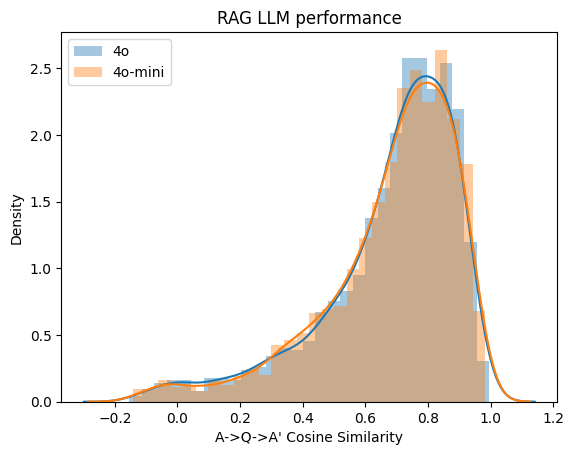

In [38]:
sns.distplot(df_gpt4o['cosine'], label='4o')
sns.distplot(df_gpt4o_mini['cosine'], label='4o-mini')

plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()

/tmp/ipykernel_17035/983110214.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o['cosine'], label='4o')
/tmp/ipykernel_17035/983110214.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt35['cosine'], label='3.5-turbo')


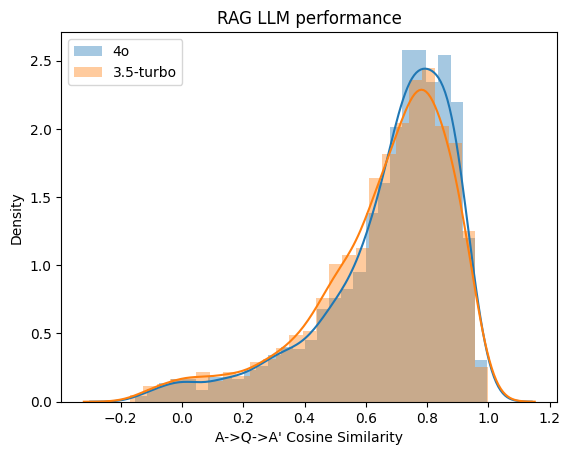

In [39]:
sns.distplot(df_gpt4o['cosine'], label='4o')
sns.distplot(df_gpt35['cosine'], label='3.5-turbo')

plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()

/tmp/ipykernel_17035/239285762.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o_mini['cosine'], label='4o-mini')
/tmp/ipykernel_17035/239285762.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt35['cosine'], label='3.5-turbo')


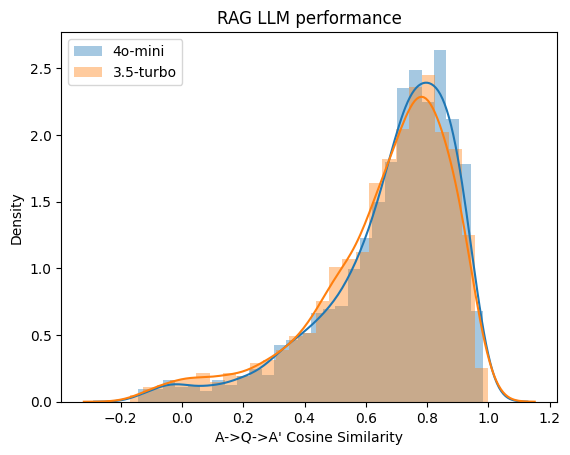

In [40]:
sns.distplot(df_gpt4o_mini['cosine'], label='4o-mini')
sns.distplot(df_gpt35['cosine'], label='3.5-turbo')

plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()

## LLM-as-a-Judge

In [28]:
prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_orig}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [29]:
df_sample = df_gpt4o_mini.sample(n=150, random_state=1)

In [30]:
samples = df_sample.to_dict(orient='records')

In [31]:
record = samples[0]
record

{'answer_llm': 'The syntax for using `precision_recall_fscore_support` in Python is as follows:\n\n```python\nfrom sklearn.metrics import precision_recall_fscore_support\nprecision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)\n```',
 'answer_orig': 'Scikit-learn offers another way: precision_recall_fscore_support\nExample:\nfrom sklearn.metrics import precision_recall_fscore_support\nprecision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)\n(Gopakumar Gopinathan)',
 'document': '403bbdd8',
 'question': 'What is the syntax for using precision_recall_fscore_support in Python?',
 'course': 'machine-learning-zoomcamp',
 'cosine': 0.9010756015777588}

In [32]:
prompt = prompt1_template.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: Scikit-learn offers another way: precision_recall_fscore_support
Example:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)
(Gopakumar Gopinathan)
Generated Question: What is the syntax for using precision_recall_fscore_support in Python?
Generated Answer: The syntax for using `precision_recall_fscore_support` in Python is as follows:

```python
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_

In [41]:
import json
answer = llm(prompt, model='phi3')
json.loads(answer)

{'Relevance': 'RELEVANT',
 'Explanation': 'The generated answer is relevant because it accurately presents the Python syntax provided in the original answer. Both answers show how to use `precision_recall_fscore_support` from sklearn and provide identical code for its implementation.'}

In [43]:
evaluations = []

for record in tqdm(samples):
    prompt = prompt1_template.format(**record)
    evaluation = llm(prompt, model='phi3')
    evaluations.append(evaluation)

  0%|          | 0/150 [00:00<?, ?it/s]

KeyboardInterrupt: 

Execution stopped due to it taking too much time to finish, results have already been calculated for better LLMs, I am just going to use them.

In [ ]:
json_evaluations = []

for i, str_eval in enumerate(evaluations):
    json_eval = json.loads(str_eval)
    json_evaluations.append(json_eval)

In [44]:
# df_evaluations = pd.DataFrame(json_evaluations)
df_evaluations = pd.read_csv("LLMaaS_results/evaluations-aqa.csv")

In [45]:
df_evaluations.Relevance.value_counts()

Relevance
RELEVANT           124
PARTLY_RELEVANT     16
NON_RELEVANT        10
Name: count, dtype: int64

In [46]:
df_evaluations[df_evaluations.Relevance == 'NON_RELEVANT'] #.to_dict(orient='records')

,Relevance,Explanation
4,NON_RELEVANT,The generated answer discusses a pip version e...
11,NON_RELEVANT,The generated answer does not address the spec...
27,NON_RELEVANT,The generated answer incorrectly states that t...
41,NON_RELEVANT,The generated answer provides information abou...
87,NON_RELEVANT,The generated answer does not address the orig...
90,NON_RELEVANT,The generated answer responds to a question ab...
93,NON_RELEVANT,The generated answer does not address the topi...
116,NON_RELEVANT,The generated answer discusses the recommended...
138,NON_RELEVANT,The generated answer addresses a different iss...
139,NON_RELEVANT,The generated answer does not relate to the to...


In [50]:
df_evaluations.iloc[4].Explanation

"The generated answer discusses a pip version error related to Scikit-Learn, which is not directly connected to the original answer's focus on a Docker build error and wheel version compatibility for Python 9. The topics of the errors are different and do not address the same issue described in the original answer."

In [48]:
samples[4]

{'answer_llm': "The cause of the pip version error in this week's serverless deep learning section could be a version conflict in Scikit-Learn. Specifically, if you are using a different version than what was used during the model training, it can lead to warnings and potential breaking code or invalid results. To resolve this, make sure to use the same version of Scikit-Learn that was used for training the model. For instance, if you trained with version 1.1.1, you should use that same version in your virtual environment.",
 'answer_orig': 'When running docker build -t dino-dragon-model it returns the above error\nThe most common source of this error in this week is because Alex video shows a version of the wheel with python 8, we need to find a wheel with the version that we are working on. In this case python 9. Another common error is to copy the link, this will also produce the same error, we need to download the raw format:\nhttps://github.com/alexeygrigorev/tflite-aws-lambda/raw

In [51]:
prompt = prompt2_template.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: What command launches a container image in interactive mode?
Generated Answer: The command to launch a container image in interactive mode is:

```
docker run -it --entrypoint bash <image>
```

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}


In [52]:
evaluation = llm(prompt, model='phi3')
print(evaluation)

{
  "Relevance": "RELEVANT",
  "Explanation": "The generated answer provides the specific command syntax used to launch a container image in an interactive mode, which directly addresses the question. The inclusion of `--entrypoint bash` suggests that the user can execute commands within this shell after starting the Docker container."
}


In [54]:
evaluations_2 = []

for record in tqdm(samples):
    prompt = prompt2_template.format(**record)
    evaluation = llm(prompt, model='phi3')
    evaluations_2.append(evaluation)

  0%|          | 0/150 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
json_evaluations_2 = []

for i, str_eval in enumerate(evaluations_2):
    json_eval = json.loads(str_eval)
    json_evaluations_2.append(json_eval)

In [55]:
# df_evaluations_2 = pd.DataFrame(json_evaluations_2)
df_evaluations_2 = pd.read_csv("LLMaaS_results/evaluations-qa.csv")

In [59]:
df_evaluations_2.Relevance.value_counts()

Relevance
RELEVANT           129
PARTLY_RELEVANT     18
NON_RELEVANT         3
Name: count, dtype: int64

In [56]:
df_evaluations_2[df_evaluations_2.Relevance == 'NON_RELEVANT']

,Relevance,Explanation
45,NON_RELEVANT,The generated answer does not address the ques...
49,NON_RELEVANT,The generated answer explicitly states that th...
139,NON_RELEVANT,The generated answer provides information abou...


In [57]:
samples[45]

{'answer_llm': 'The provided context does not include specific commands to start the Docker daemon on Linux. Therefore, I cannot provide an answer based solely on the facts from the context.',
 'answer_orig': 'Working on getting Docker installed - when I try running hello-world I am getting the error.\nDocker: Cannot connect to the docker daemon at unix:///var/run/docker.sock. Is the Docker daemon running ?\nSolution description\nIf you’re getting this error on WSL, re-install your docker: remove the docker installation from WSL and install Docker Desktop on your host machine (Windows).\nOn Linux, start the docker daemon with either of these commands:\nsudo dockerd\nsudo service docker start\nAdded by Ugochukwu Onyebuchi',
 'document': '4b2a3181',
 'question': 'What commands should I use to start the docker daemon on Linux?',
 'course': 'machine-learning-zoomcamp',
 'cosine': 0.51130211353302}

In [58]:
df_evaluations_2.iloc[45].Explanation

'The generated answer does not address the question about starting the Docker daemon on Linux and states that it cannot provide an answer, thus failing to provide any relevant information or commands related to the query.'